This example does this...... write in Markdown





In [3]:
#importing standard modules
import math
import os
import glob
import re
import matplotlib.pyplot as plt
import numpy as np
import subprocess as sub
import shutil
import sys
import scipy as sci
import scipy.io as sio
%matplotlib inline
from scipy.sparse import csr_matrix, rand
from mpl_toolkits.basemap import Basemap
import matplotlib.colors as colors
from matplotlib.pyplot import register_cmap,get_cmap,colorbar
from mpl_toolkits.axes_grid1 import make_axes_locatable
####################       IMPORT PM's MODULES     ######################################
from plottingPM import get_colors,grayify_cmap,make_colormap,customcolorpalette
from drawmapsection3D import get_distaz,delazgc_helper,writejson,readjson, \
    plot_hotspots,plot_plates,plot_gcpaths,get_fullpath,sanitised_input,uniquenumpyrow

In [4]:
####SETUP
Database_Path = '../rem3d/files/'
N = 7
Jmax = 4
WaveletBasisFn = 'D4'
eo =0
EulerConfig = 1
ModelName = 'ME16_Vp'

##Naming Conventions
DVBasisName = 'DVmaps.'+ 'N' + str(N) + '.J' + str(Jmax) + '.' + WaveletBasisFn + '.mat'
WaveletCoeffBasisName = 'WCoeffs.' + 'N'+str(N) + '.J' + str(Jmax) + '.' + \
                        WaveletBasisFn + '.mat'
GridName= 'Grid_N' + str(N) + '_Jmax' + str(Jmax) + \
          '_EulerConfig' + str(EulerConfig) + '.mat'
VeloName = ModelName + '.N' + str(N) + '.Jmax' + str(Jmax) +  \
          '.EulerConfig' + str(EulerConfig) + '.mat'

####Read
WaveletBasis = sio.loadmat(Database_Path + DVBasisName)
WaveletCoeffBasis = sio.loadmat(Database_Path + WaveletCoeffBasisName)
Grids = sio.loadmat(Database_Path + GridName)
ModelFile = sio.loadmat(Database_Path + VeloName)
####

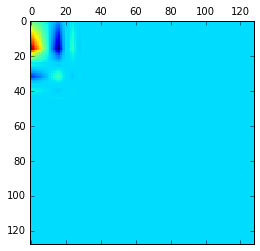

In [5]:
#Plot a wavelet on x,y
Nbasis = len(WaveletBasis['Me'][0,:])
ii = 0 # Choose a wavelet
plt.matshow(WaveletBasis['Me'][0,1][0].toarray())

In [6]:
#Plot a wavelet from a selected face
face = 6 #out of 0-5
ii = 1 #0-16383


N = Grids['MetaN'][0][0]
ScaleIndex = Grids['ScaleIndex'][0][0]
print ScaleIndex
Jmax = Grids['MetaJmax'][0][0]
lonwav = Grids['lon'][face*Nbasis:(face+1)*Nbasis]
latwav = Grids['lat'][face*Nbasis:(face+1)*Nbasis]
value = WaveletBasis['Me'][0,ii][0].toarray()
value = value.flatten()

# Define a colorscale
colormax=np.amax(abs(value)) #(-colormax,colormax) are the limits of the colorbar
greylimit=0.001*colormax  #this is the limit to which the middle color (grey) will extend on either side of colorttmax mid
name='r_lgrey_b'
c = colors.ColorConverter().to_rgb
colorlist=[c('blue'), c('lightgray'), (2.*colormax-2.*greylimit)/(4.*colormax), c('lightgray'),c('lightgray'), (2.*colormax+2.*greylimit)/(4.*colormax), c('lightgray'),c('red'), 1., c('red')]
custom_cmap = make_colormap(colorlist,name)
register_cmap(name=custom_cmap.name, cmap=custom_cmap)
palette=custom_cmap.name

colorVal=get_colors(val=value,xmin=-colormax,xmax=colormax,palette=palette)
print colorVal.shape,value.shape,lonwav.shape

5
(16384, 4) (16384,) (0, 1)


IndexError: index 0 is out of bounds for axis 0 with size 0

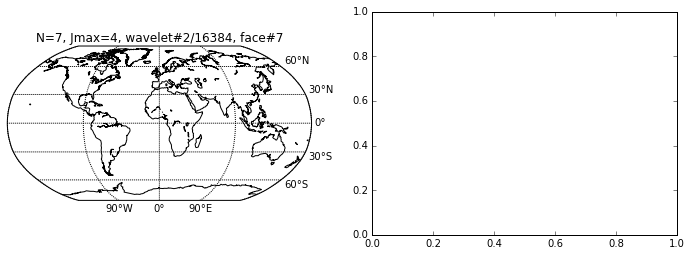

In [7]:
# Make the figure
fig = plt.figure(figsize=(12, 4), dpi=300, facecolor='w')

ax = fig.add_subplot(121)
m = Basemap(projection='robin', lon_0=0,resolution='c',ax=ax)
m.drawcoastlines()
x, y = m(lonwav,latwav); 
cm = get_cmap(palette)
sc = ax.scatter(x, y, c=colorVal, vmin=-colormax, vmax=colormax, edgecolor= '', cmap=cm)
  
# Set title
titlestr='N='+str(N)+', Jmax='+str(Jmax)+', wavelet#'+str(ii+1) \
            +'/'+str(Nbasis)+', face#'+str(face+1)
ax.set_title(titlestr,fontsize=12)

# draw parallels and meridians.
# labels = [left,right,top,bottom]
parallels = np.arange(-60,90,30.)
m.drawparallels(parallels,labels=[False,True,False,False])
meridians = np.arange(0.,360.,90.)
m.drawmeridians(meridians,labels=[False,False,False,True])

####### Plot within the face
ax = fig.add_subplot(122)
findnonzeros = np.where(value != 0.)   
lonwavsel=lonwav[findnonzeros];latwavsel=latwav[findnonzeros]
colorValsel=colorVal[findnonzeros] ;valuesel=value[findnonzeros]

m = Basemap(projection='cyl',llcrnrlat=min(latwavsel)-5.,urcrnrlat=max(latwavsel)+5.,\
            llcrnrlon=min(lonwavsel)-5.,urcrnrlon=max(lonwavsel)+5.,resolution='c',ax=ax)
m.drawcoastlines()
m.drawcoastlines()
x, y = m(lonwavsel,latwavsel); 
cm = get_cmap(palette)
sc = ax.scatter(x, y, c=colorValsel, vmin=-colormax, vmax=colormax, edgecolor= '', cmap=cm)
ax.set_title('Non-zero points',fontsize=12) 
    
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("left", size="5%", pad=0.1)	
#cbar=colorbar(sc, cax=cax, orientation="horizontal",ticklocation="top")
#tick_locator = ticker.MaxNLocator(nbins=9)
#cbar.locator = tick_locator
#cbar.update_ticks()
#cbar.ax.tick_params(labelsize=12) 



# draw parallels and meridians.
spacing = int((max(latwavsel)-min(latwavsel))/2.)
parallels = np.arange(-90,90,spacing)
m.drawparallels(parallels,labels=[False,True,False,False])
spacing = int((max(lonwavsel)-min(lonwavsel))/2.)
meridians = np.arange(-180.,180.,spacing)
m.drawmeridians(meridians,labels=[False,False,False,True])

plt.show()

In [ ]:
print Grids['MetaEulerNames'][0][0][0]
print Grids['MetaEulerVals'][0]
print Grids['face'][:,0]